In [1]:
# This is a Bayesian Neural Network implementation using TensorFlow for a simple y = sin(x) function

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# Check if GPU is available
print("GPU Available: ", tf.test.is_gpu_available())
print("GPU Name: ", tf.test.gpu_device_name())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available:  True
GPU Name:  /device:GPU:0


U_star shape:  (5000, 2, 200)
N:  5000
T:  200
15
(334, 200)
(66800, 1)
(66800, 1)
(66800, 1)
(66800, 1)
(66800, 1)
(66800, 1)


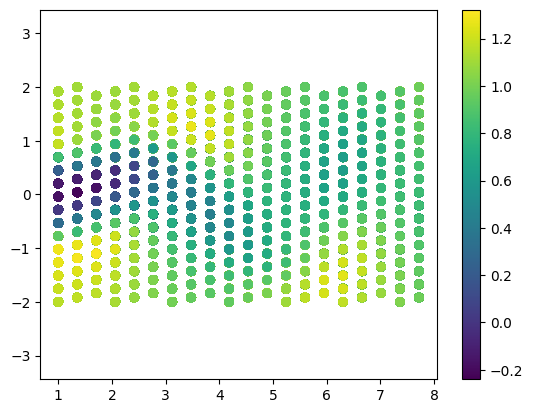

(334, 3)
x min:  1.0
x max:  7.717171717171717
y min:  -2.0
y max:  2.0
x gap:  0.3535353535353536
y gap:  0.08163265306122458


In [3]:
import numpy as np
import scipy.io
# Load Data
data = scipy.io.loadmat('cylinder_nektar_wake.mat')
        
nu = 1/100
U_star = data['U_star'] # N x 2 x T
P_star = data['p_star'] # N x T
t_star = data['t'] # T x 1
X_star = data['X_star'] # N x 2
print("U_star shape: ", U_star.shape)

N = X_star.shape[0]
T = t_star.shape[0]
print("N: ", N)
print("T: ", T)

# Rearrange Data 
XX = np.tile(X_star[:,0:1], (1,T)) # N x T
YY = np.tile(X_star[:,1:2], (1,T)) # N x T
TT = np.tile(t_star, (1,N)).T # N x T

UU = U_star[:,0,:] # N x T
VV = U_star[:,1,:] # N x T
PP = P_star # N x T

# Take every step-th of XX, YY, TT, UU, VV, PP
'''increment_step = 10
XX = XX[::increment_step,::increment_step] # N/step x T/step
YY = YY[::increment_step,::increment_step]
#TT = TT[::increment_step,::increment_step]
UU = UU[::increment_step,::increment_step]
VV = VV[::increment_step,::increment_step]
PP = PP[::increment_step,::increment_step]'''
increment_step = 15
XX = XX[::increment_step,:]
YY = YY[::increment_step,:]
TT = TT[::increment_step,:]
UU = UU[::increment_step,:]
VV = VV[::increment_step,:]
PP = PP[::increment_step,:]

print(increment_step)
print(XX.shape)

x = XX.flatten()[:,None] # NT x 1
y = YY.flatten()[:,None] # NT x 1
t = TT.flatten()[:,None] # NT x 1

u = UU.flatten()[:,None] # NT x 1
v = VV.flatten()[:,None] # NT x 1
p = PP.flatten()[:,None] # NT x 1

# Print the shape of the data
print(x.shape)
print(y.shape)
print(t.shape)
print(u.shape)
print(v.shape)
print(p.shape)

# Plot scatter of x y u
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(x, y, c=u)
plt.colorbar()
plt.axis('equal')
plt.show()

# u0, v0, p0 are the initial conditions
u0 = UU[:,0:1]
v0 = VV[:,0:1]
p0 = PP[:,0:1]

initial_data = np.concatenate([u0, v0, p0], 1)
print(initial_data.shape)

# Print min and max of x and y
print("x min: ", np.min(x))
print("x max: ", np.max(x))
print("y min: ", np.min(y))
print("y max: ", np.max(y))

# Unique x and y
X = np.unique(x)
Y = np.unique(y)

# Print the gap between the points
print("x gap: ", X[1] - X[0])
print("y gap: ", Y[1] - Y[0])

(334, 3)
(334, 3)


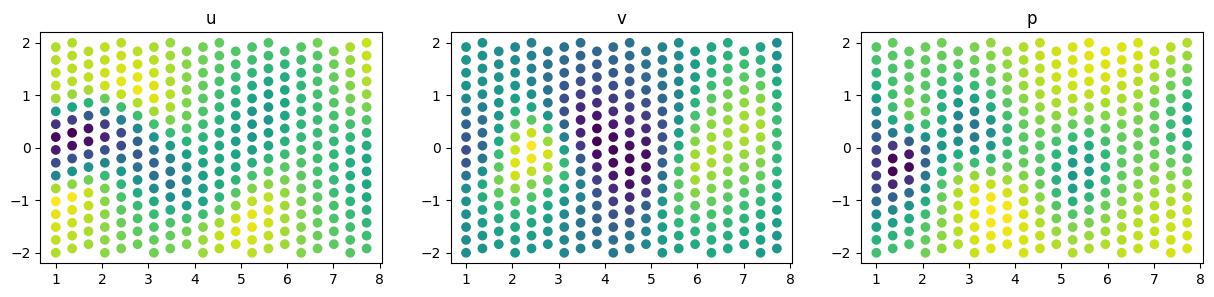

In [4]:
# Create training data for selected timestep only
timestep = 11
X_tf = np.concatenate([XX[:,timestep:timestep+1], YY[:,timestep:timestep+1], TT[:,timestep:timestep+1]], 1).astype(np.float32) # NT x 3
Y_tf = np.concatenate([UU[:,timestep:timestep+1], VV[:,timestep:timestep+1], PP[:,timestep:timestep+1]], 1).astype(np.float32) # NT x 3
#X_tf = np.concatenate([XX[:,timestep:timestep+1], YY[:,timestep:timestep+1]], 1).astype(np.float32) # NT x 3
print(X_tf.shape)
print(Y_tf.shape)

# Plot scatter of training date for u, v and p for selected timestep, in 3 subplots
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(15, 3)
axs[0].scatter(X_tf[:,0], X_tf[:,1], c=Y_tf[:,0])
axs[0].set_title('u')
axs[1].scatter(X_tf[:,0], X_tf[:,1], c=Y_tf[:,1])
axs[1].set_title('v')
axs[2].scatter(X_tf[:,0], X_tf[:,1], c=Y_tf[:,2])
axs[2].set_title('p')
plt.show()

In [5]:
def a_pinn(model, input_data, t, output_data, nu):
    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch(input_data) 
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(input_data)

            x = input_data[:,0:1]
            y = input_data[:,1:2]
            #t = input_data[:,2:3]

            u = model.forward(tf.concat([x,y], axis=1))[:,0:1]
            v = model.forward(tf.concat([x,y], axis=1))[:,1:2]
            p = model.forward(tf.concat([x,y], axis=1))[:,2:3]

            # Convert u v p to float64
            u = tf.cast(u, tf.float32)
            v = tf.cast(v, tf.float32)
            p = tf.cast(p, tf.float32)
            
        # 1st order
        u_x = tape.gradient(u, x)
        v_x = tape.gradient(v, x)
        p_x = tape.gradient(p, x)
        u_y = tape.gradient(u, y)
        v_y = tape.gradient(v, y)
        p_y = tape.gradient(p, y)
        #u_t = tape.gradient(u, t)
        #v_t = tape.gradient(v, t)
        #p_t = tape.gradient(p, t)
    
    # 2nd order
    u_xx = tape2.gradient(u_x, x)
    v_xx = tape2.gradient(v_x, x)
    p_xx = tape2.gradient(p_x, x)
    u_yy = tape2.gradient(u_y, y)
    v_yy = tape2.gradient(v_y, y)
    p_yy = tape2.gradient(p_y, y)
    
    # Compute residual
    f_u = u*u_x + v*u_y + p_x - 1/500*(u_xx + u_yy)
    f_v = u*v_x + v*v_y + p_y - 1/500*(v_xx + v_yy)
    f_p = u_x + v_y

    residual = tf.reduce_mean(tf.square(f_u)) + tf.reduce_mean(tf.square(f_v)) + tf.reduce_mean(tf.square(f_p))

    return residual

def at_pinn(model, input_data, t, output_data, nu):
    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch(input_data) 
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(input_data)

            x = input_data[:,0:1]
            y = input_data[:,1:2]
            t = input_data[:,2:3]

            index_y = np.array([94,104,114,124,134,144,154,161,164,171,181,183,193,197,203,207,213,217,222,223,227,232,233,237,242,243,247,252,253,254,263,264,273,274,283,284,294,304,314,324,334,341,351,361,371,381,66,75,76,85,94,95,104,114,131,140,150,173,183,193,199,203,209,213,219,223,229,233,239,243,248,249,253,258,259,263,268,269,273,278,279,282,283,288,289,292,293,298,299,302,308,309,312,318,319,322,328,329,339,349,359,369,378,388,398,408,418])
            index_y = np.unique(index_y)

            u = model.forward(tf.concat([x,y,t], axis=1))[:,0:1]
            v = model.forward(tf.concat([x,y,t], axis=1))[:,1:2]
            p = model.forward(tf.concat([x,y,t], axis=1))[:,2:3]

            # Convert u v p to float64
            u = tf.cast(u, tf.float32)
            v = tf.cast(v, tf.float32)
            p = tf.cast(p, tf.float32)

            # Select u, v, p, x, y and t based on index_y
            u, v, p = np.take(u, index_y, axis=0), np.take(v, index_y, axis=0), np.take(p, index_y, axis=0)
            x, y, t = np.take(x, index_y, axis=0), np.take(y, index_y, axis=0), np.take(t, index_y, axis=0)
            
        # 1st order
        u_x = tape.gradient(u, x)
        v_x = tape.gradient(v, x)
        p_x = tape.gradient(p, x)
        u_y = tape.gradient(u, y)
        v_y = tape.gradient(v, y)
        p_y = tape.gradient(p, y)
        u_t = tape.gradient(u, t)
        v_t = tape.gradient(v, t)
    
    # 2nd order
    u_xx = tape2.gradient(u_x, x)
    v_xx = tape2.gradient(v_x, x)
    p_xx = tape2.gradient(p_x, x)
    u_yy = tape2.gradient(u_y, y)
    v_yy = tape2.gradient(v_y, y)
    p_yy = tape2.gradient(p_y, y)
    
    # Compute residual
    f_u = u_t + u*u_x + v*u_y + p_x - 1/100*(u_xx + u_yy)
    f_v = v_t + u*v_x + v*v_y + p_y - 1/100*(v_xx + v_yy)
    f_p = u_x + v_y

    residual = tf.reduce_mean(tf.square(f_u)) + tf.reduce_mean(tf.square(f_v)) + tf.reduce_mean(tf.square(f_p))

    return residual

def n_pinn(model, x, t, u, nu, scheme):
    dx = x[1] - x[0] # Assuming uniform grid  
    xE, xW = x + dx, x - dx
    uE, uW = model.forward(xE), model.forward(xW)

    if scheme == 'uw1':
        u_x = (u - uW) / (x - xW)
        u_xx = (uE - 2 * u + uW) / (x - xW)**2
    elif scheme == 'uw2':
        uWW = model.forward(x - 2 * dx)
        u_x = (3 * u - 4 * uW + uWW) / (2 * dx)
        uEE = model.forward(x + 2 * dx)
        u_xx = (-uEE + 4 * uE - 5 * u + 2 * uW) / dx**2

    residual = u * u_x - nu * u_xx
    return residual

def nt_pinn(model, input_data, t, output_data, nu, scheme):
    x = input_data[:, 0:1]
    y = input_data[:, 1:2]
    t = input_data[:, 2:3]

    # Find the difference between true and pred
    def diff_true_pred(true, pred):
        return (true - pred)
    
    diff_u = diff_true_pred(output_data[:, 0:1], model.forward(tf.concat([x, y, t], axis=1))[:, 0:1])
    diff_v = diff_true_pred(output_data[:, 1:2], model.forward(tf.concat([x, y, t], axis=1))[:, 1:2])
    diff_p = diff_true_pred(output_data[:, 2:3], model.forward(tf.concat([x, y, t], axis=1))[:, 2:3])

    # Find x y area where the difference is larger than 30% of the max difference
    def top_30_percent_area(diff):
        return np.where(np.abs(diff) > 0.3 * np.max(np.abs(diff)))
    index_u_2 = np.array(top_30_percent_area(diff_u))
    index_v_2 = np.array(top_30_percent_area(diff_v))
    index_p_2 = np.array(top_30_percent_area(diff_p))

    # Find top 30% larger absolute difference
    def top_30_percent(diff):
        return np.where(np.abs(diff) > np.percentile(np.abs(diff), 70))
    
    # Find 30% lowest values from model.log_likelihood(Y_tf, Y_pred)[1] and index
    def top_30_percent_likelihood(log_likelihood):
        return np.where(log_likelihood < np.percentile(log_likelihood, 30))
    
    index_u_3 = np.array(top_30_percent_likelihood(model.log_likelihood(output_data[:, 0:1], model.forward(tf.concat([x, y, t], axis=1))[:, 0:1])[1]))
    index_v_3 = np.array(top_30_percent_likelihood(model.log_likelihood(output_data[:, 1:2], model.forward(tf.concat([x, y, t], axis=1))[:, 1:2])[1]))
    index_p_3 = np.array(top_30_percent_likelihood(model.log_likelihood(output_data[:, 2:3], model.forward(tf.concat([x, y, t], axis=1))[:, 2:3])[1]))

    index_u = np.array(top_30_percent(diff_u))
    index_v = np.array(top_30_percent(diff_v))
    index_p = np.array(top_30_percent(diff_p))

    # Get unique index
    #index_y = np.unique(np.concatenate([index_u, index_v, index_p], axis=1))
    #index_y = np.unique(np.concatenate([index_u_2, index_v_2, index_p_2], axis=1))
    index_y = np.unique(np.concatenate([index_u_3, index_v_3, index_p_3], axis=1))

    dx = np.unique(x)[1] - np.unique(x)[0]
    dy = np.unique(y)[1] - np.unique(y)[0]
    PDE_step = 2

    # Get initial bad collocation points
    bad_x, bad_y = np.take(x, index_y, axis=0), np.take(y, index_y, axis=0)
    # Generate neighboring points
    bad_x = np.concatenate([bad_x, bad_x + dx * PDE_step, bad_x - dx * PDE_step, bad_x + dx * PDE_step, bad_x - dx * PDE_step])  # Add East & West neighbors
    bad_y = np.concatenate([bad_y, bad_y + dy * PDE_step, bad_y - dy * PDE_step, bad_y - dy * PDE_step, bad_y + dy * PDE_step])  # Add North & South neighbors
    # Remove duplicates to avoid redundant collocation points
    x, y = bad_x, bad_y
    #bad_x, bad_y = np.unique(np.stack([bad_x, bad_y], axis=1), axis=0).T
    # Compute new neighboring points after expansion
    xE, xW = bad_x + dx, bad_x - dx  # East & West
    yN, yS = bad_y + dy, bad_y - dy  # North & South
    bad_xx, bad_yy = np.take(x, index_y, axis=0), np.take(y, index_y, axis=0)
    
    #xE, xW = x + dx, x - dx
    #yN, yS = y + dy, y - dy
    #xE, xW = xE + dx, xW + dx
    #yN, yS = yN + dy, yS + dy
    #u = model.forward(tf.concat([x, y, t], axis=1))[:, 0:1]
    #v = model.forward(tf.concat([x, y, t], axis=1))[:, 1:2]
    #p = model.forward(tf.concat([x, y, t], axis=1))[:, 2:3]
    #u = output_data[:, 0:1]
    #v = output_data[:, 1:2]
    #p = output_data[:, 2:3]

    if input_data.shape[1] == 3:
        
        u, v, p = model.forward(tf.concat([x, y, t], axis=1))[:, 0:1], model.forward(tf.concat([x, y, t], axis=1))[:, 1:2], model.forward(tf.concat([x, y, t], axis=1))[:, 2:3]
        uE, uW = model.forward(tf.concat([xE, y, t], axis=1))[:, 0:1], model.forward(tf.concat([xW, y, t], axis=1))[:, 0:1]
        vE, vW = model.forward(tf.concat([xE, y, t], axis=1))[:, 1:2], model.forward(tf.concat([xW, y, t], axis=1))[:, 1:2]
        pE, pW = model.forward(tf.concat([xE, y, t], axis=1))[:, 2:3], model.forward(tf.concat([xW, y, t], axis=1))[:, 2:3]
        uN, uS = model.forward(tf.concat([x, yN, t], axis=1))[:, 0:1], model.forward(tf.concat([x, yS, t], axis=1))[:, 0:1]
        vN, vS = model.forward(tf.concat([x, yN, t], axis=1))[:, 1:2], model.forward(tf.concat([x, yS, t], axis=1))[:, 1:2]
        pN, pS = model.forward(tf.concat([x, yN, t], axis=1))[:, 2:3], model.forward(tf.concat([x, yS, t], axis=1))[:, 2:3]

        uEE = model.forward(tf.concat([x + 2 * dx, y, t], axis=1))[:, 0:1]
        uWW = model.forward(tf.concat([x - 2 * dx, y, t], axis=1))[:, 0:1]
        uNN = model.forward(tf.concat([x, y + 2 * dy, t], axis=1))[:, 0:1]
        uSS = model.forward(tf.concat([x, y - 2 * dy, t], axis=1))[:, 0:1]
        vEE = model.forward(tf.concat([x + 2 * dx, y, t], axis=1))[:, 1:2]
        vWW = model.forward(tf.concat([x - 2 * dx, y, t], axis=1))[:, 1:2]
        vNN = model.forward(tf.concat([x, y + 2 * dy, t], axis=1))[:, 1:2]
        vSS = model.forward(tf.concat([x, y - 2 * dy, t], axis=1))[:, 1:2]
        pWW = model.forward(tf.concat([x - 2 * dx, y, t], axis=1))[:, 2:3]
        pNN = model.forward(tf.concat([x, y + 2 * dy, t], axis=1))[:, 2:3]
        pSS = model.forward(tf.concat([x, y - 2 * dy, t], axis=1))[:, 2:3]

    elif input_data.shape[1] == 2:

        u, v, p = model.forward(tf.concat([x, y], axis=1))[:, 0:1], model.forward(tf.concat([x, y], axis=1))[:, 1:2], model.forward(tf.concat([x, y], axis=1))[:, 2:3]
        uE, uW = model.forward(tf.concat([xE, y], axis=1))[:, 0:1], model.forward(tf.concat([xW, y], axis=1))[:, 0:1]
        vE, vW = model.forward(tf.concat([xE, y], axis=1))[:, 1:2], model.forward(tf.concat([xW, y], axis=1))[:, 1:2]
        pE, pW = model.forward(tf.concat([xE, y], axis=1))[:, 2:3], model.forward(tf.concat([xW, y], axis=1))[:, 2:3]
        uN, uS = model.forward(tf.concat([x, yN], axis=1))[:, 0:1], model.forward(tf.concat([x, yS], axis=1))[:, 0:1]
        vN, vS = model.forward(tf.concat([x, yN], axis=1))[:, 1:2], model.forward(tf.concat([x, yS], axis=1))[:, 1:2]
        pN, pS = model.forward(tf.concat([x, yN], axis=1))[:, 2:3], model.forward(tf.concat([x, yS], axis=1))[:, 2:3]

        uEE = model.forward(tf.concat([x + 2 * dx, y], axis=1))[:, 0:1]
        uWW = model.forward(tf.concat([x - 2 * dx, y], axis=1))[:, 0:1]
        uNN = model.forward(tf.concat([x, y + 2 * dy], axis=1))[:, 0:1]
        uSS = model.forward(tf.concat([x, y - 2 * dy], axis=1))[:, 0:1]
        vEE = model.forward(tf.concat([x + 2 * dx, y], axis=1))[:, 1:2]
        vWW = model.forward(tf.concat([x - 2 * dx, y], axis=1))[:, 1:2]
        vNN = model.forward(tf.concat([x, y + 2 * dy], axis=1))[:, 1:2]
        vSS = model.forward(tf.concat([x, y - 2 * dy], axis=1))[:, 1:2]
        pWW = model.forward(tf.concat([x - 2 * dx, y], axis=1))[:, 2:3]
        pNN = model.forward(tf.concat([x, y + 2 * dy], axis=1))[:, 2:3]
        pSS = model.forward(tf.concat([x, y - 2 * dy], axis=1))[:, 2:3]    

    '''# Select all for x between -1 and 1
    u, v, p = np.take(u, index_y, axis=0), np.take(v, index_y, axis=0), np.take(p, index_y, axis=0)
    uE, uW, uS, uN = np.take(uE, index_y, axis=0), np.take(uW, index_y, axis=0), np.take(uS, index_y, axis=0), np.take(uN, index_y, axis=0)
    vE, vW, vS, vN = np.take(vE, index_y, axis=0), np.take(vW, index_y, axis=0), np.take(vS, index_y, axis=0), np.take(vN, index_y, axis=0)
    pE, pW, pS, pN = np.take(pE, index_y, axis=0), np.take(pW, index_y, axis=0), np.take(pS, index_y, axis=0), np.take(pN, index_y, axis=0)
    uEE, uWW, uSS, uNN = np.take(uEE, index_y, axis=0), np.take(uWW, index_y, axis=0), np.take(uSS, index_y, axis=0), np.take(uNN, index_y, axis=0)
    vEE, vWW, vSS, vNN = np.take(vEE, index_y, axis=0), np.take(vWW, index_y, axis=0), np.take(vSS, index_y, axis=0), np.take(vNN, index_y, axis=0)
    pWW, pSS, pNN = np.take(pWW, index_y, axis=0), np.take(pSS, index_y, axis=0), np.take(pNN, index_y, axis=0)'''

    u_x = (3 * u - 4 * uW + uWW) / (2 * dx)
    u_y = (3 * u - 4 * uS + uSS) / (2 * dy) # 
    v_x = (3 * v - 4 * vW + vWW) / (2 * dx)
    v_y = (3 * v - 4 * vS + vSS) / (2 * dy) #
    p_x = (pE - pW) / (dx)
    p_y = (pN - pS) / (dy) #
    u_xx = (-uEE + 4 * uE - 5 * u + 2 * uW) / dx**2
    u_yy = (-uNN + 4 * uN - 5 * u + 2 * uS) / (dy**2) # 
    v_xx = (-vEE + 4 * vE - 5 * v + 2 * vW) / dx**2
    v_yy = (-vNN + 4 * vN - 5 * v + 2 * vS) / (dy**2) #

    '''uc_e, uc_w = 0.5*(uE + u), 0.5*(uW + u) 
    vc_n, vc_s = 0.5*(vN + v), 0.5*(vS + v)
    div = (uc_e - uc_w) /dx + (vc_n - vc_s) /dy
    
    # 2nd upwind
    Uem_uw2 = 1.5*u  - 0.5*uW
    Uep_uw2 = 1.5*uE - 0.5*uEE  
    Uwm_uw2 = 1.5*uW - 0.5*uWW
    Uwp_uw2 = 1.5*u  - 0.5*uE
    Ue_uw2 = tf.where(tf.greater_equal(uc_e, 0.0), Uem_uw2, Uep_uw2)
    Uw_uw2 = tf.where(tf.greater_equal(uc_w, 0.0), Uwm_uw2, Uwp_uw2)
        
    Unm_uw2 = 1.5*u  - 0.5*uS
    Unp_uw2 = 1.5*uN - 0.5*uNN    
    Usm_uw2 = 1.5*uS - 0.5*uSS
    Usp_uw2 = 1.5*u  - 0.5*uN
    Un_uw2 = tf.where(tf.greater_equal(vc_n, 0.0), Unm_uw2, Unp_uw2)
    Us_uw2 = tf.where(tf.greater_equal(vc_s, 0.0), Usm_uw2, Usp_uw2)

    Vem_uw2 = 1.5*v  - 0.5*vW
    Vep_uw2 = 1.5*vE - 0.5*vEE
    Vwm_uw2 = 1.5*vW - 0.5*vWW
    Vwp_uw2 = 1.5*v  - 0.5*vE
    Ve_uw2 = tf.where(tf.greater_equal(uc_e, 0.0), Vem_uw2, Vep_uw2)
    Vw_uw2 = tf.where(tf.greater_equal(uc_w, 0.0), Vwm_uw2, Vwp_uw2)
        
    Vnm_uw2 = 1.5*v  - 0.5*vS
    Vnp_uw2 = 1.5*vN - 0.5*vNN    
    Vsm_uw2 = 1.5*vS - 0.5*vSS
    Vsp_uw2 = 1.5*v  - 0.5*vN
    Vn_uw2 = tf.where(tf.greater_equal(vc_n, 0.0), Vnm_uw2, Vnp_uw2)
    Vs_uw2 = tf.where(tf.greater_equal(vc_s, 0.0), Vsm_uw2, Vsp_uw2)
        
    UUx_uw2 = (uc_e*Ue_uw2 - uc_w*Uw_uw2) /dx
    VUy_uw2 = (vc_n*Un_uw2 - vc_s*Us_uw2) /dy
    UVx_uw2 = (uc_e*Ve_uw2 - uc_w*Vw_uw2) /dx
    VVy_uw2 = (vc_n*Vn_uw2 - vc_s*Vs_uw2) /dy
    
    # 2nd central difference    
    Uxx_cd2 = (uE - 2.0*u + uW)/ (dx*dx) 
    Uyy_cd2 = (uN - 2.0*u + uS)/ (dy*dy) 
    Vxx_cd2 = (vE - 2.0*v + vW)/ (dx*dx) 
    Vyy_cd2 = (vN - 2.0*v + vS)/ (dy*dy) 

    pe_cd2 = (p + pE) /2.0 
    pw_cd2 = (pW + p) /2.0 
    pn_cd2 = (p + pN) /2.0 
    ps_cd2 = (pS + p) /2.0 
    
    Px_cd2 = (pe_cd2 - pw_cd2) /dx
    Py_cd2 = (pn_cd2 - ps_cd2) /dy
        
    f_p = div
    f_u = UUx_uw2 + VUy_uw2 - 1.0/500 *(Uxx_cd2 + Uyy_cd2) - u*div + Px_cd2
    f_v = UVx_uw2 + VVy_uw2 - 1.0/500 *(Vxx_cd2 + Vyy_cd2) - v*div + Py_cd2 '''
    f_u = u*u_x + v*u_y + p_x - (1/100)*(u_xx + u_yy)  # x-momentum
    f_v = u*v_x + v*v_y + p_y - (1/100)*(v_xx + v_yy)  # y-momentum
    f_p = u_x + v_y                                    # incompressibility

    residual = tf.reduce_mean(tf.square(f_u)) + tf.reduce_mean(tf.square(f_v)) + tf.reduce_mean(tf.square(f_p))

    return residual, bad_x, bad_y, bad_xx, bad_yy

def can_pinn(model, x, t, u, nu, scheme):
    dx = x[1] - x[0] # Assuming uniform grid
    xE, xW = x + dx, x - dx # u(x-dx) = uW, u(x) = u, u(x+dx) = uE
    uE, uW = model.forward(xE), model.forward(xW)

    if scheme == 'uw1':
        '''uE, uW = model.forward(xE), model.forward(xW)
        a1, a2, a3 = 1, a1 * dx / 2, a1 * dx**2 / 3
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(xE, xW)
        uE_x, uW_x = tape.gradient(uE, xE), tape.gradient(uW, xW)'''

    elif scheme == 'uw2':
        
        with tf.GradientTape(persistent=True) as tape2_xE, tf.GradientTape(persistent=True) as tape2_xW, tf.GradientTape(persistent=True) as tape2_x:
            tape2_xE.watch(xE)
            tape2_xW.watch(xW)
            tape2_x.watch(x)
            with tf.GradientTape(persistent=True) as tape_xE, tf.GradientTape(persistent=True) as tape_xW, tf.GradientTape(persistent=True) as tape_x:
                tape_xE.watch(xE)
                tape_xW.watch(xW)
                tape_x.watch(x)
                uE, uW, u = model.forward(xE), model.forward(xW), model.forward(x)
            uE_x, uW_x, u_x = tape_xE.gradient(uE, xE), tape_xW.gradient(uW, xW), tape_x.gradient(u, x)
        uE_xx, uW_xx, u_xx = tape2_xE.gradient(uE_x, xE), tape2_xW.gradient(uW_x, xW), tape2_x.gradient(u_x, x)

        uEm_uw2 = u + u_x*dx/2
        uEp_uw2 = uE - uE_x*dx/2
        uWm_uw2 = uW + uW_x*dx/2
        uWp_uw2 = u - u_x*dx/2
        uE_uw2 = tf.where(u_x > 0, uEm_uw2, uEp_uw2)
        uW_uw2 = tf.where(u_x > 0, uWm_uw2, uWp_uw2)
        u_uw2 = (uE_uw2 + uW_uw2) / 2
        u_x_uw2 = (uE_uw2 - uW_uw2) / dx

        uEm_x_uw2 = u_x + u_xx * dx / 2
        uEp_x_uw2 = uE_x - uE_xx * dx / 2
        uWm_x_uw2 = uW_x + uW_xx * dx / 2
        uWp_x_uw2 = u_x - u_xx * dx / 2
        uE_x_uw2 = tf.where(u_x > 0, uEm_x_uw2, uEp_x_uw2)
        uW_x_uw2 = tf.where(u_x > 0, uWm_x_uw2, uWp_x_uw2)
        u_xx_uw2 = (uE_x_uw2 - uW_x_uw2) / dx

    residual = u_uw2 * u_x_uw2 - nu * u_xx_uw2  
    
    # save first and second terms of residual into a dataframe
    first_term = u_uw2 * u_x_uw2
    second_term = nu * u_xx_uw2

    return residual, first_term, second_term

def loss_condition(model, input_data, t, output_data, initial_data):
    
    # initial & boundary conditions:
    # Top    : u = 0 , v = 0
    # Left   : u = 1 , v = 0
    # Right  : u = 0 , v = 0
    # Bottom : u = 0 , v = 0
    # Pressure not included in the boundary conditions

    x = input_data[:, 0:1]
    y = input_data[:, 1:2]
    t = input_data[:, 2:3]

    u = model.forward(tf.concat([x, y, t], axis=1))[:, 0:1]
    v = model.forward(tf.concat([x, y, t], axis=1))[:, 1:2]
    p = model.forward(tf.concat([x, y, t], axis=1))[:, 2:3]

    # Define the initial conditions
    u0 = initial_data[:, 0:1]
    v0 = initial_data[:, 1:2]
    p0 = initial_data[:, 2:3]

    # Computational boundary
    x_left, x_right, y_btm, y_top = min(x), max(x), min(y), max(y)

    # Boundary masks
    _top = tf.equal(y, y_top)  # Top boundary (y = 0) 
    _bottom = tf.equal(y, y_btm)  # Bottom boundary (y = 0)
    _left = tf.equal(x, x_left)  # Left boundary (x = 1)
    _right = tf.equal(x, x_right)  # Right boundary (x = 0)

    u_top, v_top = tf.boolean_mask(u, _top), tf.boolean_mask(v, _top) # Top boundary: u = 0, v = 0
    u_bottom, v_bottom = tf.boolean_mask(u, _bottom), tf.boolean_mask(v, _bottom) # Bottom boundary: u = 0, v = 0
    u_left, v_left = tf.boolean_mask(u, _left), tf.boolean_mask(v, _left) # Left boundary: u = 1, v = 0
    u_right, v_right = tf.boolean_mask(u, _right), tf.boolean_mask(v, _right) # Right boundary: u = 0, v = 0

    # Compute the loss for the boundary conditions 
    bc_top = tf.compat.v1.losses.mean_squared_error(labels=tf.zeros_like(u_top), predictions=u_top) + tf.compat.v1.losses.mean_squared_error(labels=tf.zeros_like(v_top), predictions=v_top)
    bc_bottom = tf.compat.v1.losses.mean_squared_error(labels=tf.zeros_like(u_bottom), predictions=u_bottom) + tf.compat.v1.losses.mean_squared_error(labels=tf.zeros_like(v_bottom), predictions=v_bottom)
    bc_left = tf.compat.v1.losses.mean_squared_error(labels=tf.ones_like(u_left), predictions=u_left) + tf.compat.v1.losses.mean_squared_error(labels=tf.zeros_like(v_left), predictions=v_left)
    bc_right = tf.compat.v1.losses.mean_squared_error(labels=tf.zeros_like(u_right), predictions=u_right) + tf.compat.v1.losses.mean_squared_error(labels=tf.zeros_like(v_right), predictions=v_right)

    bc = bc_top + bc_bottom + bc_left + bc_right

    return bc

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math
from sklearn.model_selection import train_test_split

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define the neural network architecture
class BayesianNeuralNetwork:
    def __init__(self, input_dim, hidden_layers, output_dim, dropout_rate=0., prior_std=1.0):
        # Initialize weights and biases as TensorFlow variables
        initializer = tf.initializers.GlorotUniform()
        #initializer = tf.keras.initializers.HeNormal()

        self.weights = [
            tf.Variable(initializer([input_dim, hidden_layers[0]]), dtype=tf.float32)
        ] + [
            tf.Variable(initializer([hidden_layers[i], hidden_layers[i+1]]), dtype=tf.float32)
            for i in range(len(hidden_layers) - 1)
        ] + [
            tf.Variable(initializer([hidden_layers[-1], output_dim]), dtype=tf.float32)
        ]
        
        self.biases = [
            tf.Variable(tf.zeros([size]), dtype=tf.float32) for size in hidden_layers + [output_dim]
        ]

        # Prior parameters (assuming Gaussian priors)
        self.prior_std = prior_std
        self.prior_vars = [
            tf.constant(self.prior_std**2, dtype=tf.float32) for _ in self.weights + self.biases]
        
        self.dropout_rate = dropout_rate

    def forward(self, X, training=True):
        hidden_activation = tf.nn.tanh(tf.matmul(X, self.weights[0]) + self.biases[0])
        if training:
            hidden_activation = tf.nn.dropout(hidden_activation, rate=self.dropout_rate)
        
        for i in range(1, len(self.weights) - 1):
            hidden_activation = tf.nn.tanh(tf.matmul(hidden_activation, self.weights[i]) + self.biases[i])
            if training:
                hidden_activation = tf.nn.dropout(hidden_activation, rate=self.dropout_rate)
        
        # Output layer (linear activation)
        output = tf.matmul(hidden_activation, self.weights[-1]) + self.biases[-1]
        return output

    
    def log_prior(self): # Role: Define initial beliefs about each parameter, acting as regularizers.
        # Compute log prior probability of weights and biases
        log_prior = 0.0
        for var, var_prior_var in zip(self.weights + self.biases, self.prior_vars):
            # Assuming Gaussian prior: log p(w) = -0.5 * log(2πσ²) - w²/(2σ²)
            #log_prior += -0.5 * tf.reduce_sum(tf.math.log(2.0 * np.pi * var_prior_var**2)) # log(2πσ²)
            log_prior += -tf.reduce_sum(tf.square(var)) / (2.0 * var_prior_var**2) # -w²/(2σ²)
        log_prior_store.append(log_prior)
        return log_prior

    def log_likelihood(self, Y_true, Y_pred): # Role: Represents the probability of observing the data given the parameters, modeling how well the network fits the data.
        # Assuming Gaussian likelihood: p(Y|X,w) = N(Y_pred, σ²)
        # log p(Y|X,w) = -0.5 * log(2πσ²) - (Y - Y_pred)^2 / (2σ²)
        #log_likelihood = -0.5 * tf.cast(tf.size(Y_true), tf.float32) * tf.math.log(2.0 * np.pi * likelihood_std**2) # log(2πσ²)
        likelihood_std = np.std(Y_pred)
        log_likelihood = 0.0
        log_likelihood += -tf.reduce_sum(tf.square(Y_true - Y_pred)) / (2.0 * likelihood_std**2) # -(Y - Y_pred)^2 / (2σ²)
        log_likelihood_data = -(tf.square(Y_true - Y_pred)) / (2.0 * likelihood_std**2)
        log_likelihood_store.append(log_likelihood)
        return log_likelihood, log_likelihood_data, likelihood_std

    def log_posterior(self, Y_true, Y_pred): # Role: Combines priors and likelihood to update beliefs about parameters after observing the data.
        # log posterior ∝ log likelihood + log prior
        #print("Likelihood:   ", self.log_likelihood(Y_true, Y_pred))
        #print("Prior:   ", self.log_prior())
        log_posterior_store.append(self.log_likelihood(Y_true, Y_pred)[0] + self.log_prior())
        return self.log_likelihood(Y_true, Y_pred)[0] + self.log_prior()

# Define the loss function (negative log posterior)
def negative_log_posterior(model, Y_true, Y_pred):
    return -model.log_posterior(Y_true, Y_pred)

# Initialize the Bayesian neural network
Y_tf = np.concatenate([UU[:,timestep:timestep+1], VV[:,timestep:timestep+1], PP[:,timestep:timestep+1]], 1).astype(np.float32) # NT x 3
X_tf = np.concatenate([XX[:,timestep:timestep+1], YY[:,timestep:timestep+1], TT[:,timestep:timestep+1]], 1).astype(np.float32) # NT x 3
X_tf = np.concatenate([XX[:,timestep:timestep+1], YY[:,timestep:timestep+1]], 1).astype(np.float32) # NT x 3
if X_tf.shape[1] == 2:
    input_dim = 2
elif X_tf.shape[1] == 3:
    input_dim = 3
else:
    raise ValueError("Unsupported input dimension")
hidden = 64
output_dim = 3
num_layers = 3
hidden_layers = [hidden for _ in range(num_layers)]
model = BayesianNeuralNetwork(input_dim, hidden_layers, output_dim)

# Prepare the optimizer
learning_rate = 0.01
optimizer = tf.keras.optimizers.Adam(learning_rate)  # Adam often works better for Bayesian methods

# Training parameters
epochs = 2
print_interval = 1
best_rmse = float('inf')
loss_all = []
loss_all_pde = []
loss_all_conditions = []
loss_all_data = []
first_term_all = []
second_term_all = []
val_loss_all = []
log_prior_store = []
log_likelihood_store = []
log_posterior_store = []
loss_posterior_all = []
val_posterior_all = []
lr_all = []
rmse_train_all = []
# initialise the loss components
#loss_posterior = np.float32(0); loss_pde = np.float32(0); loss_conditions = np.float32(0); loss_data = np.float32(0); val_loss = np.float32(0); val_posterior = np.float32(0); loss = np.float32(0)

# Convert data to TensorFlow tensors
# min-max scaling
#Xmin = np.min(X_tf, axis=0)
#Xmax = np.max(X_tf, axis=0)
#Ymin = np.min(Y_tf, axis=0)
#Ymax = np.max(Y_tf, axis=0)
#X_tf = (X_tf - Xmin)/(Xmax - Xmin)
#Y_tf = (Y_tf - Ymin)/(Ymax - Ymin)

#X_tf = (X_tf - np.mean(X_tf, axis=0)) / np.std(X_tf, axis=0)
#Y_tf = (Y_tf - np.mean(Y_tf, axis=0)) / np.std(Y_tf, axis=0)

#\X_tf = tf.convert_to_tensor(X_tf)
#Y_tf = tf.convert_to_tensor(Y_tf)

batch_size = 32  # Define batch size as the number of rows in X_tf
num_batches = math.ceil(X_tf.shape[0] / batch_size)

# Create batches using tf.data.Dataset
dataset = tf.data.Dataset.from_tensor_slices((X_tf, Y_tf))
dataset = dataset.shuffle(buffer_size=10000).batch(batch_size)
# Create batches using tf.data.Dataset without shuffling
#dataset = tf.data.Dataset.from_tensor_slices((X_tf, Y_tf)).batch(batch_size, drop_remainder=True)

# Split the data into training and validation sets using scikit-learn
X_train, X_val, Y_train, Y_val = train_test_split(X_tf, Y_tf, test_size=0.6, random_state=42)

# Create batches for training and validation sets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_dataset = train_dataset.shuffle(buffer_size=10000).batch(batch_size, drop_remainder=True)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val))
val_dataset = val_dataset.batch(batch_size, drop_remainder=True)
import tensorflow as tf

# Training loop with validation
with tf.device('/device:GPU:0'):
    for epoch in range(1, epochs + 1):
        epoch_loss_posterior, epoch_loss_pde = 0, 0

        # Training step
        for step, (X_batch, Y_batch) in enumerate(train_dataset):
            with tf.GradientTape() as tape:
                Y_pred = model.forward(X_batch, training=True)
                loss_posterior = negative_log_posterior(model, Y_batch, Y_pred)
                loss_pde = nt_pinn(model, X_batch, T, Y_batch, nu, 'uw2')[0]
                bad_x = nt_pinn(model, X_batch, T, Y_batch, nu, 'uw2')[1]
                bad_y = nt_pinn(model, X_batch, T, Y_batch, nu, 'uw2')[2]
                xx = nt_pinn(model, X_batch, T, Y_batch, nu, 'uw2')[3]
                yy = nt_pinn(model, X_batch, T, Y_batch, nu, 'uw2')[4]
                loss = loss_posterior + loss_pde  # Adjust weight here if needed

            # Compute gradients and apply clipping
            gradients = tape.gradient(loss, model.weights + model.biases)
            clipped_gradients = [tf.clip_by_value(g, -1.0, 1.0) for g in gradients if g is not None]
            optimizer.apply_gradients(zip(clipped_gradients, model.weights + model.biases))

            # Accumulate losses for logging
            epoch_loss_posterior += loss_posterior
            epoch_loss_pde += loss_pde
            loss_all.append(loss)
            loss_posterior_all.append(loss_posterior)
            loss_all_pde.append(loss_pde)

        # Normalize losses
        epoch_loss_posterior /= num_batches
        epoch_loss_pde /= num_batches

        # Validation step
        val_loss, val_posterior = 0, 0
        for X_val_batch, Y_val_batch in val_dataset:
            Y_val_pred = model.forward(X_val_batch, training=False)
            val_posterior += negative_log_posterior(model, Y_val_batch, Y_val_pred)
            val_loss += tf.reduce_mean(tf.square(Y_val_batch - Y_val_pred))

        # Normalize validation losses
        val_loss /= num_batches
        val_posterior /= num_batches
        val_loss_all.append(val_loss)
        val_posterior_all.append(val_posterior)

        # Print progress every 'print_interval' epochs
        if epoch % print_interval == 0 or epoch == 1:
            rmse_train = tf.sqrt(tf.reduce_mean((Y_tf - model.forward(X_tf))**2))
            rmse_train_all.append(rmse_train)
            print(f"Epoch {epoch} --- RMSE: {rmse_train.numpy():.10f}")

            # Save best weights if RMSE improves
            if rmse_train < best_rmse:
                best_rmse = rmse_train
                MAP_weights = model.weights[:]
                MAP_biases = model.biases[:]
                best_epoch = epoch
                print("Improved RMSE. Saved weights and biases.")

'''

# Training loop
with tf.device('/device:GPU:0'):
    for epoch in range(1, epochs + 1):
        loss_pde = nt_pinn(model, X_tf, T, Y_tf, nu, 'uw2')# sigma^2 = 1/(2*weight), weight = 1/(2*sigma^2)
        with tf.GradientTape(persistent=True) as tape: # this tape is used to calculate the gradients of the loss function with respect to the weights and biases
            # Forward pass
            Y_pred = model.forward(X_tf)
            loss_posterior = negative_log_posterior(model, Y_tf, Y_pred)

            #train_constant = np.mean(loss_posterior)/np.mean(loss_pde)
            loss = loss_posterior #+ loss_pde #* train_constant #+ loss_conditions        
            
        loss_all_data.append(loss_posterior)
        loss_all_pde.append(loss_pde)
        #loss_all_conditions.append(loss_conditions)
        loss_all.append(loss)

        loss_chosen = loss

        gradients = tape.gradient(loss_chosen, model.weights + model.biases) # Purpose of gradient: To update the weights and biases in the direction that minimizes the loss function.
        # Apply gradients
        optimizer.apply_gradients(zip(gradients, model.weights + model.biases))

        # Print the learning rate
        lr_all.append(optimizer._decayed_lr(tf.float32)) # Print the learning rate
        
        # Print loss every 'print_interval' epochs
        if epoch % print_interval == 0 or epoch == 1:
            print(f'Epoch {epoch} --- Loss = {loss_chosen.numpy():.6f}')   
            rmse_train = tf.sqrt(tf.reduce_mean((Y_tf - Y_pred)**2))
            print(f"RMSE: {rmse_train.numpy():.10f} --- loss_data: {loss_posterior.numpy():.10f} --- loss_pde: {loss_pde.numpy():.10f} --- lr: {optimizer._decayed_lr(tf.float32)}")

        # Save weights and biases only if lower rmse than before
        if rmse_train < best_rmse:
            best_rmse = rmse_train
            MAP_weights = model.weights
            MAP_biases = model.biases
            best_epoch = epoch
            if epoch % print_interval == 0 or epoch == 1:
                #print("Improvement in RMSE. Weights and biases saved.")
                print("----------------------------------------")
        else:
            if epoch % print_interval == 0 or epoch == 1:
                print("No improvement in RMSE. Weights and biases not saved.")
                print("----------------------------------------")

        # plot likelihood
        plt.figure()
        plt.plot(-1*model.log_likelihood(Y_tf, Y_pred)[1])
        plt.title('Likelihood')
        plt.show()

        # Plot likelihood density distribution for 3 components separately
        plt.figure()
        plt.hist(-1*model.log_likelihood(Y_tf, Y_pred)[1][:,0], bins=100, alpha=0.5, label='u')
        plt.hist(-1*model.log_likelihood(Y_tf, Y_pred)[1][:,1], bins=100, alpha=0.5, label='v')
        plt.hist(-1*model.log_likelihood(Y_tf, Y_pred)[1][:,2], bins=100, alpha=0.5, label='p')
        plt.title('Likelihood density distribution')
        plt.legend()
        plt.show()

        aaa = model.log_likelihood(Y_tf, Y_pred)[1]
        # Save model into pkl
        import pickle
        with open('model_likelihood_data_opti.pkl', 'wb') as file:
            pickle.dump(model, file)'''

c:\Users\User\anaconda3\envs\goat\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1 --- RMSE: 0.6015266180
Improved RMSE. Saved weights and biases.
Epoch 2 --- RMSE: 0.4483319521
Improved RMSE. Saved weights and biases.


'\n\n# Training loop\nwith tf.device(\'/device:GPU:0\'):\n    for epoch in range(1, epochs + 1):\n        loss_pde = nt_pinn(model, X_tf, T, Y_tf, nu, \'uw2\')# sigma^2 = 1/(2*weight), weight = 1/(2*sigma^2)\n        with tf.GradientTape(persistent=True) as tape: # this tape is used to calculate the gradients of the loss function with respect to the weights and biases\n            # Forward pass\n            Y_pred = model.forward(X_tf)\n            loss_posterior = negative_log_posterior(model, Y_tf, Y_pred)\n\n            #train_constant = np.mean(loss_posterior)/np.mean(loss_pde)\n            loss = loss_posterior #+ loss_pde #* train_constant #+ loss_conditions        \n            \n        loss_all_data.append(loss_posterior)\n        loss_all_pde.append(loss_pde)\n        #loss_all_conditions.append(loss_conditions)\n        loss_all.append(loss)\n\n        loss_chosen = loss\n\n        gradients = tape.gradient(loss_chosen, model.weights + model.biases) # Purpose of gradient: T

(22, 1)
(22, 1)
(110, 1)
(110, 1)


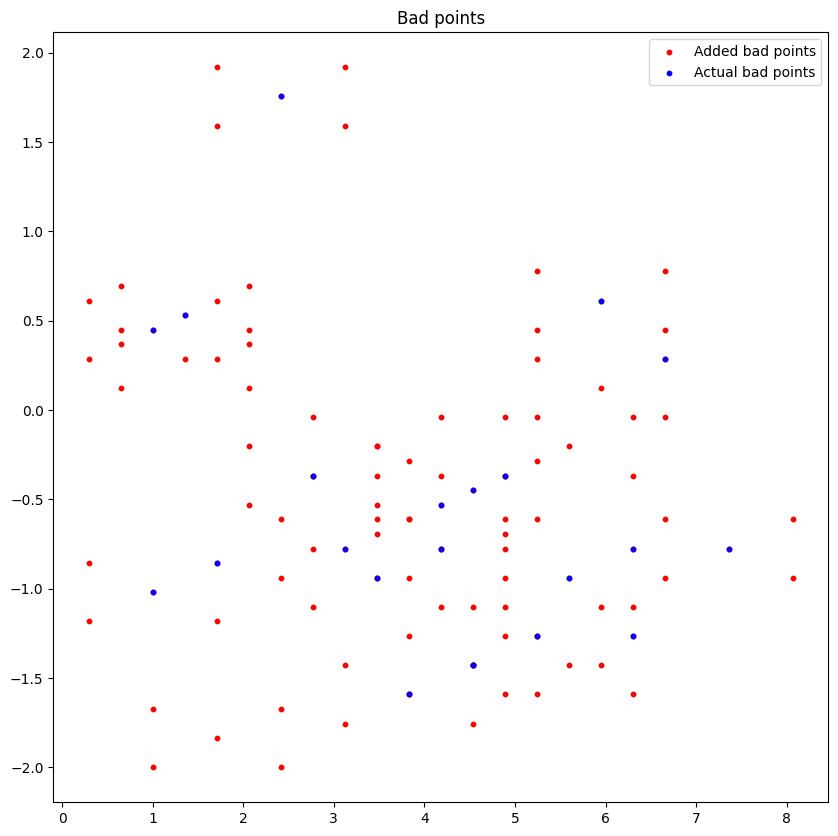

In [7]:
# print shape
print(xx.shape) 
print(yy.shape)
print(bad_x.shape)
print(bad_y.shape)

# Plot bad points
plt.figure(figsize=(10, 10))
plt.scatter(bad_x, bad_y, c='r', s=10, label="Added bad points")
plt.scatter(xx, yy, c='b', s=10, label="Actual bad points")
plt.title('Bad points')
plt.legend()
plt.show()


input:  (334, 2)
output  (334, 3)
Best epoch at:  2
RMSE: 0.44833195
Loss: 85.74986267


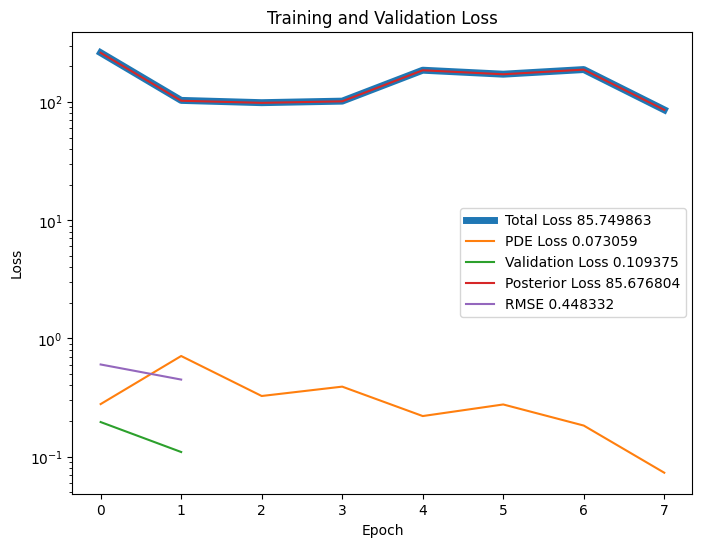

RMSE u: 0.31061211
RMSE v: 0.48173976
RMSE p: 0.52388126


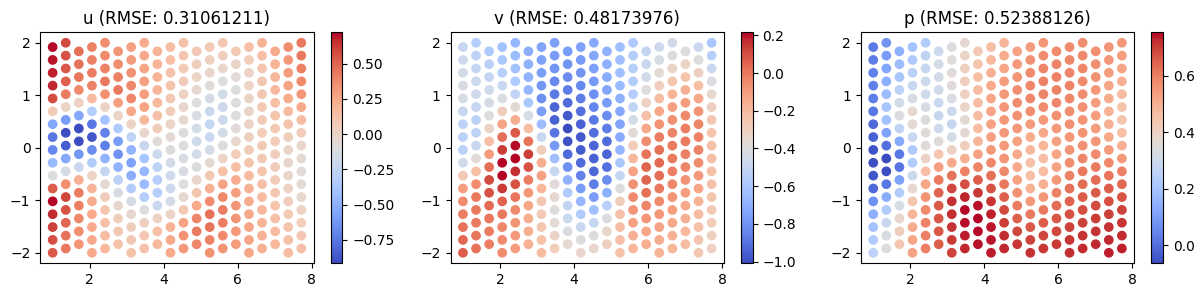

Output size:  (334, 3)


ValueError: cannot reshape array of size 32 into shape (50,20)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

# Print RMSE
model.weights = MAP_weights
model.biases = MAP_biases
U_pred = model.forward(X_tf)
print('input: ', X_tf.shape)
print('output ', U_pred.shape)
rmse = tf.sqrt(tf.reduce_mean(tf.square(Y_tf - U_pred)))
print("Best epoch at: ", best_epoch)
print(f"RMSE: {rmse.numpy():.8f}")

# Convert loss to anti-log:
print(f"Loss: {(loss.numpy()):.8f}")

# Plot the loss if any of the required loss components are available
plt.figure(figsize=(8, 6))
if loss_all:
    plt.plot(loss_all, linewidth=5, label=f'Total Loss {loss_all[-1].numpy():.6f}')
if loss_all_data:
    plt.plot(loss_all_data, label=f'Data Loss {loss_all_data[-1].numpy():.6f}')
if loss_all_pde:
    plt.plot(loss_all_pde, label=f'PDE Loss {loss_all_pde[-1].numpy():.6f}')
if loss_all_conditions:
    plt.plot(loss_all_conditions, label=f'Conditions Loss {loss_all_conditions[-1].numpy():.6f}')
if val_loss_all:
    plt.plot(val_loss_all, label=f'Validation Loss {val_loss_all[-1].numpy():.6f}')
if loss_posterior_all:
    plt.plot(loss_posterior_all, label=f'Posterior Loss {loss_posterior_all[-1].numpy():.6f}')
if rmse_train_all:
    plt.plot(rmse_train_all, label=f'RMSE {rmse_train_all[-1].numpy():.6f}')
plt.axhline(y=0, color='b', linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.yscale('log')
# save the plot
#plt.savefig("loss_plot_CANPINN_NS_0.1PDE2.png")
plt.show()


# Plot the normalised data
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(15, 3)
sc0 = axs[0].scatter(X_tf[:,0], X_tf[:,1], c=Y_tf[:,0] - U_pred[:,0], cmap='coolwarm')
fig.colorbar(sc0, ax=axs[0])
axs[0].set_title('u')
sc1 = axs[1].scatter(X_tf[:,0], X_tf[:,1], c=Y_tf[:,1] - U_pred[:,1], cmap='coolwarm')
fig.colorbar(sc1, ax=axs[1])
axs[1].set_title('v')
sc2 = axs[2].scatter(X_tf[:,0], X_tf[:,1], c=Y_tf[:,2] - U_pred[:,2], cmap='coolwarm')
fig.colorbar(sc2, ax=axs[2])
axs[2].set_title('p')
# Calculate and print RMSE for u, v, p
rmse_u = tf.sqrt(tf.reduce_mean(tf.square(Y_tf[:, 0] - U_pred[:, 0])))
rmse_v = tf.sqrt(tf.reduce_mean(tf.square(Y_tf[:, 1] - U_pred[:, 1])))
rmse_p = tf.sqrt(tf.reduce_mean(tf.square(Y_tf[:, 2] - U_pred[:, 2])))

print(f"RMSE u: {rmse_u.numpy():.8f}")
print(f"RMSE v: {rmse_v.numpy():.8f}")
print(f"RMSE p: {rmse_p.numpy():.8f}")

# Add RMSE to the plot titles
axs[0].set_title(f'u (RMSE: {rmse_u.numpy():.8f})')
axs[1].set_title(f'v (RMSE: {rmse_v.numpy():.8f})')
axs[2].set_title(f'p (RMSE: {rmse_p.numpy():.8f})')
plt.savefig("RMSE_plot_CANPINN_NS_0.1PDE2.png")
plt.show()

# Print output size
print("Output size: ", U_pred.shape)

# Mesh grid for X and Y
X, Y = np.meshgrid(np.unique(X_tf[:, 0]), np.unique(X_tf[:, 1]))
U = Y_pred[:, 0].numpy().reshape(X.shape)
V = Y_pred[:, 1].numpy().reshape(X.shape)
P = Y_pred[:, 2].numpy().reshape(X.shape)

# Make the 3D plot rotatable

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, UU[:,timestep:timestep+1].reshape(X.shape), cmap='Blues')
ax.plot_surface(X, Y, U, cmap='Reds')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('U')
ax.set_title('3D Surface plot of U')

# Enable rotation
def rotate(angle):
    ax.view_init(azim=angle)


ani = FuncAnimation(fig, rotate, frames=np.arange(0, 360, 1), interval=100)
plt.show()

In [ ]:
# Print X_tf and Y_tf shape
print("X_tf shape: ", X_tf.shape)
print("Y_tf shape: ", Y_tf.shape)

# Sampling;

# Initialise MAP from model parameters
model.weights = MAP_weights
model.biases = MAP_biases
MAP = model.weights + model.biases
samples = []; new_sample = []; momentum_norm_total = []; alphas = []; proposed_H_store = []; grad_list_total = []; negative_log_posterior_list_total = []; acceptance_list = []
propose_H = 0

# Hyperparameters for HMC
num_samples = 100
step_size = 0.001 # try smaller stepsizes, cfl condition whether the step size is too large
num_leapfrog_steps = 1000

# Get gradients of the log posterior with respect to the model parameters
def grad_log_posterior(model, X, Y):
    with tf.GradientTape() as tape:
        Y_predd = model.forward(X)
        loss = negative_log_posterior(model, Y, Y_predd)
    return tape.gradient(loss, model.weights + model.biases)

# Hamiltonian Monte Carlo sampling
def hmc_sampling(model, X, Y, num_samples, step_size, num_leapfrog_steps):
    samples = [] # List to store samples
    current_sample = MAP # Start from the MAP estimate
    #current_log_prob = negative_log_posterior(model, Y, model.forward(X)).numpy()

    num_accepted = 0
    num_rejected = 0

    with tf.device('/GPU:0'):
        for k in range(num_samples):
            # Sample momentum from a Gaussian distribution
            momentum = [tf.random.normal(w.shape) for w in current_sample]
            '''# Plot momentum distribution
            print("Momentum size:" , momentum[1].numpy().ravel().shape)
            plt.figure(figsize=(10, 5))
            plt.hist(momentum[1].numpy().ravel(), bins=50)
            plt.title('Momentum')
            plt.show()'''

            # Compute the current and proposed log probabilities
            current_H = negative_log_posterior(model, Y, model.forward(X)).numpy() + 0.5 * sum((m**2).numpy().sum() for m in momentum)
            
            momentum_norm_list = []
            grad_list = []
            negative_log_posterior_list = []

            # Leapfrog integration
            new_sample = samples[-1] if samples else current_sample
            
            for l in range(num_leapfrog_steps):
                # Make a half step for momentum at the beginning
                momentum = [m - 0.5 * step_size * g for m, g in zip(momentum, grad_log_posterior(model, X, Y))]

                # Make a full step for the position
                new_sample = [w + step_size * m for w, m in zip(new_sample, momentum)]
                new_sample = [tf.Variable(w) for w in new_sample] 
                num_weights = len(new_sample) // 2
                model.weights = new_sample[:num_weights]
                model.biases = new_sample[num_weights:]
                # Make a full step for the momentum, except at the end of the trajectory
                if l < num_leapfrog_steps - 1:
                    momentum = [m - 0.5 * step_size * g for m, g in zip(momentum, grad_log_posterior(model, X, Y))]

                # Calculate the momentum norm for each weight and bias
                momentum_norm = [tf.norm(m).numpy() for m in momentum]
                momentum_norm_list.append(momentum_norm)
                grad_norm = [tf.norm(g).numpy() for g in grad_log_posterior(model, X, Y)]
                grad_list.append(grad_norm)
                negative_log_posterior_list.append(negative_log_posterior(model, Y, model.forward(X)).numpy())  


                #print("Step: ", l+1)
                #print("Momentum Norm: ", momentum_norm)
            '''# Plot momentum norm
            plt.figure(figsize=(10, 5))
            plt.plot(momentum_norm_list)
            plt.title('Momentum Norm')
            plt.show()'''

            # Append momentum norm for every sample
            momentum_norm_total.append(momentum_norm_list)
            grad_list_total.append(grad_list)
            negative_log_posterior_list_total.append(negative_log_posterior_list)
                                
            proposed_H = negative_log_posterior(model, Y, model.forward(X)).numpy() + 0.5 * sum((m**2).numpy().sum() for m in momentum)
            print(negative_log_posterior(model, Y, model.forward(X)).numpy())
            print(0.5 * sum((m**2).numpy().sum() for m in momentum))
            proposed_H_store.append(proposed_H)

            # Accept or reject the new sample
            p = np.random.uniform()
            alpha = min(1, np.exp(proposed_H - current_H)) # proposed_H must be less than current_H to accept the sample
            alphas.append(alpha)    
            if p >= alpha: # alpha >= p  or p <= alpha
                print("Accepted")
                num_accepted = num_accepted + 1
                current_sample = new_sample
                samples.append(current_sample)
                acceptreject = 1
            else:
                print("Rejected")
                num_rejected = num_rejected + 1
                current_sample = current_sample
                acceptreject = 0

            # Print p and alpha
            print("p: ", p, " AND alpha: ", alpha)

            # Acceptance rate
            acceptance_rate = 100 * num_accepted / (num_accepted + num_rejected)
            acceptance_list.append(acceptreject)
            print("Acceptance Rate: ", acceptance_rate)
            print("-------------------------- Sample: ", k+1, "--------------------------------")

    return samples, momentum_norm_total, alphas, proposed_H_store, current_H, grad_list_total, negative_log_posterior_list_total, acceptance_list

# Perform HMC sampling
samples, momentum_norm_total, alphas, proposed_H_store, current_H, grad_list_total, negative_log_posterior_list_total, acceptance_list = hmc_sampling(model, X_tf, Y_tf, num_samples, step_size, num_leapfrog_steps)

X_tf shape:  (1000, 3)
Y_tf shape:  (1000, 3)


KeyboardInterrupt: 

In [ ]:
import pickle
#with open('CANPINN-NS-0.1PDE2.pkl', 'wb') as f:
    pickle.dump(MAP_weights, f)
    pickle.dump(MAP_biases, f)